# Inverse Fourier 

The Inverse fourier reconstruction is a temptative algorithm to reconstruct tracks in the NEXT experiment.

It is based on recovering an original 2D image, called source ($s(x,y)$), using the measured image ($m(x,y)$), if the convolution function ($h(x,y)$) is known.

$\displaystyle m(x,y) = s(x,y) \odot h(x,y) $

Using the inverse fourier:

$\displaystyle s(x,y) = F^{-1} [ \, F m(x,y) / \, Fh (x,y) ]$

Where $F$ is the Fourier transform.



## Image generation

We generate random points with an intensity in a given range in a $n\times n$ grid. Each point is then smaeared with a gaussian with sigma $s$

### Utilities with arrays 

In [1]:
#from __future__ import print
import numpy as  np
from scipy.stats import norm
from copy import deepcopy

def arnull(ndim=2,size=11):
    """ create a null array of dimension ndim and given size
    """
    kk = [0.]*size
    for i in range(2,ndim):
        kk = [kk,]*size
    ar = np.array([kk,]*size)
    return ar

def argaus(ndim=2,size=11,sigmas=[1.,1.]):
    """ create an n-dim array with gaussian in each proyection. 
    The gaussian are centered in the middle of the array with a given sigmas
    """
    if (len(sigmas) != ndim): raise IndexError('not squared array')
    ar = arnull(ndim,size)
    indexes = range(size)
    i0 = int(size/2.)
    xs = map(lambda k: map(lambda i: float(norm.pdf(float(i-i0)/sigmas[k])),indexes), range(ndim))
    def ijkprod(x,xar,ilevel):
        xi = x
        for k in range(size):
            xk = float(xs[ilevel][k])
            if (ilevel == ndim-1): xar[k] = xi*xk
            else: ijkprod(xi*xk,xar[k],ilevel+1)
    ijkprod(1.,ar,0)
    return ar 

def arnorma(ar):
    """ returns the norma of the array, that is, the sum of all its elements.
    """
    ndim = len(ar.shape)
    x = ar
    for i in range(ndim): x=sum(x)
    return x

def arnormalize(ar):
    """ normalize the array, that is, the sum of it elements is one.
    """
    norma = arnorma(ar)
    ar = ar/norma
    return ar

def arlast(ar):
    """ move the last slice of the array into the first elements, move the rest one index.
    This method is required to re-establish the array properly after use the fourier scipy methods.
    """
    ss = ar.shape
    ndim, size = len(ss),ss[0]
    if (sum(ss) != ndim*size): 
        raise IndexError('not squared array!')
    def ilast(xar,xor,ilevel):
        xar[0]=xor[-1]
        for i in range(size-1): 
            xar[i+1]=xor[i]
        if (ilevel==ndim-1): return
        for i in range(size):
            ilast(xar[i],xor[i],ilevel+1)
    br = deepcopy(ar)
    cr = deepcopy(ar)
    ilast(br,cr,0)
    return br

In [2]:
#check that the functions works
def archeck():
    print("# null array")
    a = arnull(ndim=3,size=2)
    print('a = ',a)

    print("# gaussian array")
    ag = argaus(ndim=3,size=3,sigmas=[0.5,0.5,0.5])
    print('ag = ',ag)

    print("# norma of the array")
    norma = arnorma(ag)
    print('ag norma = ',norma)
    print("# normalize the array")
    ag = arnormalize(ag)
    print('ag normalized ',arnorma(ag)) 

    print("# move the last items to first and move the rest of elements one")
    ag = argaus(ndim=3,size=3,sigmas=[0.5,0.5,0.5])
    print(' ag original = ',ag)
    ag2 = arlast(ag)
    print(' ag changed = ',ag2)

    return

In [3]:
archeck()

# null array
('a = ', array([[[ 0.,  0.],
        [ 0.,  0.]],

       [[ 0.,  0.],
        [ 0.,  0.]]]))
# gaussian array
('ag = ', array([[[ 0.00015738,  0.00116293,  0.00015738],
        [ 0.00116293,  0.00859293,  0.00116293],
        [ 0.00015738,  0.00116293,  0.00015738]],

       [[ 0.00116293,  0.00859293,  0.00116293],
        [ 0.00859293,  0.06349364,  0.00859293],
        [ 0.00116293,  0.00859293,  0.00116293]],

       [[ 0.00015738,  0.00116293,  0.00015738],
        [ 0.00116293,  0.00859293,  0.00116293],
        [ 0.00015738,  0.00116293,  0.00015738]]]))
# norma of the array
('ag norma = ', 0.13026540914780169)
# normalize the array
('ag normalized ', 1.0)
# move the last items to first and move the rest of elements one
(' ag original = ', array([[[ 0.00015738,  0.00116293,  0.00015738],
        [ 0.00116293,  0.00859293,  0.00116293],
        [ 0.00015738,  0.00116293,  0.00015738]],

       [[ 0.00116293,  0.00859293,  0.00116293],
        [ 0.00859293,  0.063493

### fourier methods

In [4]:
import numpy as np
from scipy.fftpack import fftn,ifftn,fftshift
import numpy as np
from copy import deepcopy
import Sequences

# aliases
SH  = np.fft.fftshift
FT  = lambda x:  ( fftn( x ) ) #         Fourier transform
IFT = lambda x:  fftshift( ifftn( x )  ) # Inverse Fourier transform

def armesfourier(sig,res):
    """ return an array with the measurement providing the signal and resolution arrays
    """
    fsig = FT(sig)
    fres = FT(res)
    fmes = Sequences.Multiply(fsig,fres)
    mes = IFT(fmes)
    mes = Sequences.Apply(mes,lambda x: x.real)
    mes = arlast(mes)
    return mes

def arrecfourier(mes,res):
    """ return the signal array providing the measurement and the resolution arrays
    """
    fmes = FT(mes)
    fres = FT(res)
    fresinv = Sequences.Apply(fres,lambda x: 1/x)
    fsig = Sequences.Multiply(fmes,fresinv)
    sig = IFT(fsig)
    sig = Sequences.Apply(sig,lambda x: x.real)
    return sig

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

('xs = ', [1, 1, 0, 0, -1, 1, 0, -1, 0, -1])
('snake = ', [(7, 7), (8, 6), (8, 6), (8, 7), (7, 6), (8, 7), (8, 6), (7, 6), (7, 6), (6, 7)])


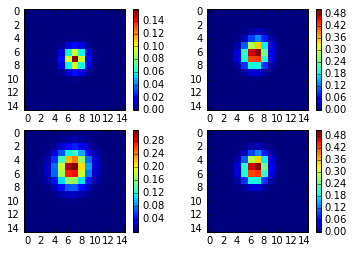

In [6]:
import random

def generate_image(size,xs):
    ar = arnull(2,size)
    for xi,yi in xs: ar[xi][yi]=1.
    return ar

def generate_snake(x0,y0,size):
    xs = random.sample([-1,0,1]*size,size)
    ys = random.sample([-1,0,1]*size,size)
    print('xs = ',xs)
    xs[0],ys[0] = x0,y0
    for i in range(1,size): 
        xs[i] = xs[i]+xs[i-1]
        ys[i] = ys[i]+ys[i-1]
    zz = zip(xs,ys)
    return zz
 
size=15
res = argaus(2,size,[1.,1.])
snake = generate_snake(7,7,10)
print('snake = ',snake)
sig = generate_image(size,snake)
sig = armesfourier(sig,res)
mes = armesfourier(sig,res)
rec = arrecfourier(mes,res)

def arplot(ar,index):
    plt.subplot(220+index)
    plt.imshow(ar,interpolation='nearest')
    plt.colorbar()
    return

arplot(res,1)
arplot(sig,2)
arplot(mes,3)
arplot(rec,4)
plt.savefig('fourier.png')
